In [22]:
%matplotlib inline

In [23]:
import networkx as nx
import numpy as np
import scipy
import pandas as pd
import random

from matplotlib import pyplot as plt

from data_helpers import make_polarized_graphs
from core import query_graph_using_dense_matrix, sweep_on_x
from helpers import flatten


In [24]:
random.seed(12345)
np.random.seed(12345)

size = 10
k = 2 
g, true_comms, true_groupings = make_polarized_graphs(k, [(size, size) for i in range(k)])
A = nx.adj_matrix(g, weight='sign')

# check if the correlation constraint is tight (from SDP)

In [25]:
import numpy as np
from scipy.sparse.linalg import eigs

import cvxpy as cp

from helpers import (
    signed_laplacian,
    prepare_seed_vector,
    degree_diag,
    is_rank_one,
    sbr_by_threshold
)

kappa = 0.7

seeds = [
    [4], [13],
]


n = g.number_of_nodes()
L = signed_laplacian(g).A
D = degree_diag(g).A

s = prepare_seed_vector(seeds, D)

# requirement check
_, v1 = eigs(np.real(L), k=1, which='SM')
assert not np.isclose((s.T @ np.real(v1))[0, 0], 0)

DsDsT = (D @ s) @ (D @ s).T

X = cp.Variable((n, n))
constraints = [
    X >> 0,
    cp.trace(D @ X) == 1,
    cp.trace(DsDsT @ X) >= kappa
]
prob = cp.Problem(cp.Minimize(cp.trace(L @ X)), constraints)

opt_val = prob.solve(eps=1e-10)

print('alpha=', constraints[1].dual_value)
print('beta=', constraints[2].dual_value)
assert np.isclose(constraints[2].residual, 0), "correlation constraint should be tight!"

x_opt = X.value[0, :]
D_sq = np.diag(np.sqrt(np.diag(D)))
# normalize to such that x^T D x = 1
x_opt = x_opt / np.sqrt(x_opt @ D @ x_opt[:, None])

# x^T D x = 1
assert np.isclose(x_opt @ D @ x_opt[:, None], 1)

# s^T D x = 1
assert np.isclose((x_opt @ D @ s)**2, kappa, atol=1e-3)

print(np.argsort(x_opt))

WARN: m less than n, problem likely degenerate
alpha= 0.198893609536022
beta= 1.0038596859017648
[13 18 17 10 11 14 12 15 19 16 30 39 21 35 33 36 37 31 38 34 25 22 20 26
 24 29 32 23 27 28  8  9  0  5  2  1  7  6  3  4]


## conclusion

- correlation constraint is tight

# solve linear system usnig $\alpha^{*}$ (numerical stability issue could arise)

In [26]:
n = g.number_of_nodes()
L = signed_laplacian(g)
D = degree_diag(g)


In [27]:
from numpy import linalg as LA
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve
b = D @ s

alpha_opt = constraints[1].dual_value
A = L - alpha_opt * D  

# is it numerically stable? as we assume L - \alpha^{*} D has rank n-1
y = spsolve(A, b)

# normalize so that y^T D y = 1
y /= LA.norm(y, 2)
y = diags(1 / np.sqrt(D.diagonal())) @ y[:, None]

assert np.isclose((y.T @ D @ y)[0, 0], 1), 'y not normalized w.r.t D'

print('y/x_opt', y.T / x_opt)
print('y', y.T)
print('node order', np.argsort(y.T))

y/x_opt [[ -1.96139505  -1.4524639   -2.1238421   -1.47171285  -0.16989237
   -2.06202635  -1.55462491  -2.13929172  -2.79051998  -2.07333373
   -1.29733388  -1.47127753  -1.89263965   0.06284787  -1.94613782
   -1.8347658   -5.35781326  -1.49651444  -1.52940226  -1.1050006
    8.30868916 -10.11231598   8.78899135   1.1801487    6.45196518
   11.58674796   9.17816119   1.14380505   0.0609099    8.67645437
    0.96192606  16.85314891  -9.46436153   3.00677005  15.52706097
    7.91917134  12.56938482  13.18641059  14.73612463   1.56945348]]
y [[-0.0574527  -0.0580015  -0.07641299 -0.06339318 -0.0275918  -0.06883934
  -0.06314604 -0.08681728 -0.06516751 -0.05643026  0.0498793   0.05500156
   0.06466768 -0.01044185  0.07144404  0.05782207  0.06849034  0.05941406
   0.06218344  0.02328673  0.00994615  0.01359103  0.01028192  0.0045221
   0.00884245  0.01195837  0.01203348  0.00447351  0.00024927  0.0123085
  -0.00375429 -0.01382279 -0.01417022 -0.00304701 -0.01104062 -0.01059764
  -0.012679

In [28]:
lam_1 = eigs(A, k=1, which='SM')[0][0]
lam_n = eigs(A, k=1, which='LM')[0][0]
print('lambda_1=', lam_1) # <--almost 0 because of rank reduction
print('lambda_n=', lam_n)
print('condition number =', abs(lam_n / lam_1))

lambda_1= (-0.8519099893484773+0j)
lambda_n= (15.92531716412138+0j)
condition number = 18.693661728630186


# relation  between $\alpha$ and correlation constraint residual

In [29]:
from scipy.sparse.linalg import eigs, spsolve, cg

s = prepare_seed_vector(seeds, D)

n = g.number_of_nodes()
L = signed_laplacian(g)
D = degree_diag(g)

# lb = - g.number_of_edges() * 2
lb = -2
lambda1 = eigs(L, k=1, which='SM')[0][0]  # THIS IS WRONG!!!! Use the **normalized** Laplacian
ub = np.real(lambda1)

b = D @ s
gamma_list = np.linspace(lb, ub, 1000)
gap_list = []
y_list = []
print(A.shape, b.shape)
for gamma in gamma_list:
    A = L - gamma * D
    if True:
        # conjugate gradient solver
        y, info = cg(A, b)
        if info != 0:
            print('error, info=', info)
    else:
        # linear system solver
        y = spsolve(A, b)
        
    y /= LA.norm(y, 2)
    y = diags(1 / np.sqrt(D.diagonal())) @ y[:, None]

    assert np.isclose((y.T @ D @ y)[0, 0], 1), 'y not normalized w.r.t D'

    gap = (np.sqrt(kappa) - y.T @ D @ s)[0, 0]
    
    y_list.append(y)
    gap_list.append(gap)

(40, 40) (40, 1)


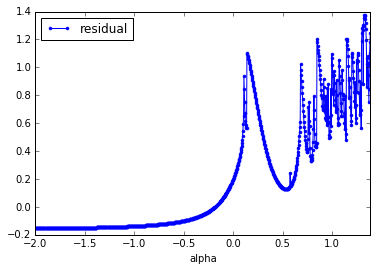

In [30]:
df = pd.DataFrame.from_dict({'y': y_list, 'alpha': gamma_list, 'residual': gap_list})
df['abs_residual'] = df['residual'].abs()
df.plot(x='alpha', y='residual', style=['.-'])

### questions

- why the fluctuations from 0.0 upwards?
- why the best $\alpha$ here is different from the $\alpha$ in SDP?

In [31]:
df.sort_values(by='abs_residual', ascending=True).head(10)

,alpha,residual,y,abs_residual
536,-0.183790,0.000621,"[[0.03156807432367406], [0.04112115231024713],...",0.000621
535,-0.187179,-0.001451,"[[0.03138253376730166], [0.04093080458090798],...",0.001451
537,-0.180402,0.002731,"[[0.03175543312517406], [0.04131290404695293],...",0.002731
534,-0.190567,-0.003486,"[[0.03119879457733433], [0.040741857883688865]...",0.003486
538,-0.177013,0.004880,"[[0.03194462688327459], [0.0415060621549289], ...",0.004880
533,-0.193955,-0.005484,"[[0.03101683973298032], [0.04055430867099873],...",0.005484
539,-0.173625,0.007069,"[[0.032135672115284425], [0.0417006283455375],...",0.007069
532,-0.197344,-0.007446,"[[0.030836652094924023], [0.0403681528598232],...",0.007446
540,-0.170236,0.009299,"[[0.03232858511559456], [0.041896603634072056]...",0.009299
531,-0.200732,-0.009374,"[[0.030658214427329314], [0.040183385866682644...",0.009374


In [32]:
min_pos = df['abs_residual'].idxmin()
print('min_pos', min_pos)
print(df.iloc[min_pos])

min_pos 536
alpha                                                    -0.18379
residual                                              0.000620934
y               [[0.03156807432367406], [0.04112115231024713],...
abs_residual                                          0.000620934
Name: 536, dtype: object


In [33]:
print('x_opt(SDP) / y:', df.iloc[min_pos].y.T / x_opt)

x_opt(SDP) / y: [[1.07771194 1.02974908 1.00218376 0.96095702 0.96349426 1.00176999
  0.96157006 1.24317896 0.97846892 1.03732259 0.99158415 0.96054483
  0.96688204 1.03701798 1.0786745  0.99908685 1.0834897  0.93138703
  0.93142046 1.06775708 1.14102158 0.9437951  1.09758494 1.10534923
  1.09095222 1.03157305 1.14280023 1.10258652 1.10265224 1.18984706
  1.10529734 1.21617174 0.93849277 1.04306492 1.16284959 1.05691426
  1.15427166 1.2014746  1.07693653 0.93726841]]


### what is strange?

- `x_opt` (by SDP) and `y` (by linear solver) really close, even though the $\alpha$ they used is different

In [34]:
print('alpha from SDP: ', alpha_opt)
print('alpha from linear solver', df.iloc[min_pos].alpha)
print('**their signs are', alpha_opt * df.iloc[min_pos].alpha > 0 and "same" or "**different!**")

alpha from SDP:  0.198893609536022
alpha from linear solver -0.18379012753640223
**their signs are **different!**


In [35]:
print('y:', np.sort(df.iloc[min_pos].y.T))
print('node order: ', np.argsort(df.iloc[min_pos].y.T))

y: [[-0.17229521 -0.03959887 -0.03812398 -0.03787031 -0.03697758 -0.03590856
  -0.03303641 -0.03148591 -0.02250187 -0.01385053 -0.00431385 -0.00273143
  -0.00141439 -0.00126847 -0.00116435 -0.00112809 -0.00105702 -0.00099749
  -0.00085965 -0.00082685  0.00106466  0.00128402  0.00136589  0.00140513
   0.00149516  0.00149832  0.00168793  0.00423548  0.0043123   0.00451254
   0.02285036  0.02823298  0.03156807  0.0334434   0.03605723  0.03905723
   0.04112115  0.04139267  0.050451    0.15647871]]
node order:  [[13 14 10 18 17 11 12 15 19 16 30 39 35 21 36 37 33 31 38 34 25 22 20 32
  24 26 29 23 27 28  8  9  0  5  2  6  1  3  7  4]]


# binary search on best $\alpha$

In [15]:
from core import query_graph_using_sparse_linear_solver

x_opt_sp, val_opt = query_graph_using_sparse_linear_solver(g, seeds, kappa, verbose=1)

matrices loading done
found lambda_1= (0.10625088207286182+0j)
at iteration 5 (alpha=-16.52207)
residual: sqrt(kappa) - y' D s=-0.16243300775250202
at iteration 10 (alpha=-0.41338)
residual: sqrt(kappa) - y' D s=-0.08410848378875846
terminates after 14 iterations:
  - alpha=-0.18604
  - residual=-0.00076


In [16]:
# difference w.r.t to the x_opt by SDP
ratio = x_opt_sp / x_opt
pd.Series(ratio).describe()

count    40.000000
mean      1.045820
std       0.081768
min       0.928034
25%       0.970553
50%       1.041302
75%       1.095096
max       1.238488
dtype: float64

# running time comparison with SDP

In [17]:
from core import query_graph_using_dense_matrix
from helpers import sample_seeds

In [18]:
random.seed(12345)
np.random.seed(12345)

size = 10
k = 6
g, true_comms, true_groupings = make_polarized_graphs(k, [(size, size) for i in range(k)])
A = nx.adj_matrix(g, weight='sign')

In [19]:
def wrapper_sp():
    seeds, target_comm = sample_seeds(true_comms, true_groupings)
    query_graph_using_sparse_linear_solver(g, seeds, kappa, verbose=0)
    
def wrapper_sdp():
    seeds, target_comm = sample_seeds(true_comms, true_groupings)
    query_graph_using_dense_matrix(g, seeds, kappa, verbose=0)

In [20]:
% timeit -n10 -r1 wrapper_sp()

43.9 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)


In [21]:
% timeit -n10 -r1 wrapper_sdp()

WARN: m less than n, problem likely degenerate
WARN: m less than n, problem likely degenerate
WARN: m less than n, problem likely degenerate
WARN: m less than n, problem likely degenerate
WARN: m less than n, problem likely degenerate
WARN: m less than n, problem likely degenerate
WARN: m less than n, problem likely degenerate
WARN: m less than n, problem likely degenerate
WARN: m less than n, problem likely degenerate
WARN: m less than n, problem likely degenerate
553 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)


## conclusion

- time difference is 10 fold on a small graph